# Generating Rest Frame SEDs from a Parametric Galaxy

Building on the `make_sfzh` documents we can now see how to generate a galaxy and produce its rest-frame spectral energy distribution.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from synthesizer.filters import FilterCollection
from synthesizer.grid import Grid
from synthesizer.parametric import SFH, ZDist, Stars
from synthesizer.parametric.galaxy import Galaxy
from synthesizer.plt import single, single_histxy
from unyt import yr, Myr, Angstrom
from astropy.cosmology import Planck18 as cosmo

We begin by initialising a `Grid`:

In [2]:
grid_name = "test_grid"
grid_dir = "../../../tests/test_grid/"
grid = Grid(grid_name, grid_dir=grid_dir)

Next we can define the star formation and metal enrichment history:

In [3]:
# define the functional form of the star formation and metal enrichment histories
sfh = SFH.Constant(duration=100 * Myr)  # constant star formation
print(sfh)  # print sfh summary
metal_dist = ZDist.DeltaConstant(log10metallicity=-2.0)  # constant metallicity

# get the 2D star formation and metal enrichment history for the given SPS grid. This is (age, Z).
stars = Stars(grid.log10age, grid.metallicity, sf_hist=sfh, metal_dist=metal_dist, initial_mass=10 ** 8)
print(stars)

----------
SUMMARY OF PARAMETERISED STAR FORMATION HISTORY
<class 'synthesizer.parametric.sf_hist.Constant'>
duration: 100 Myr
median age: 50.00 Myr
mean age: 50.00 Myr
----------

----------
SUMMARY OF BINNED SFZH
median age: 50.12 Myr
mean age: 50.01 Myr
mean metallicity: 0.0100
----------



Create a `Galaxy` object using this SZFH:

In [4]:
galaxy = Galaxy(stars)

When combined with a `Grid` we can now generate the spectral energy distribution of a galaxy. There are a range of options available to us here, most depending on whether we include nebular emission and/or dust.

Let's star with just the pure stellar spectra. As you can see there is also a method on `Galaxy` objects that allows us to quickly plot spectra.

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\lambda/[\\mathrm{Å}]$', ylabel='$L_{\\nu}/[\\mathrm{erg\\ / \\ (Hz s)}]$'>)

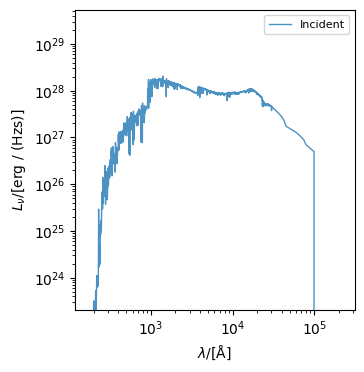

In [5]:
galaxy.stars.get_spectra_incident(grid)
galaxy.stars.plot_spectra()

However, in most cases we might like to access spectra directly. Spectra are stored within each `Galaxy` in the `spectra` dictionary.

In [6]:
sed = galaxy.stars.spectra['incident']

Spectra are stored in `Sed` objects. There is a separate tutorial on these but the contain the spectra, wavelength grid, and have access to a range of other methods, e.g. for caclulating broadband photometry.

In [7]:

print(sed)

----------
SUMMARY OF SED 
Number of wavelength points: 8228 
Wavelength range: [0.00 Å,             299293000000.00 Å] 
log10(Peak luminosity/erg/(Hz*s)):             28.31 
log10(Bolometric luminosity/             erg/s):             43.70 
----------


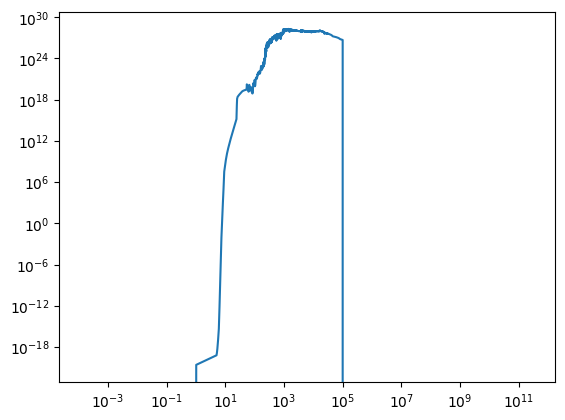

In [8]:
plt.loglog(sed.lam, sed.lnu)
plt.show()

Next, we can generate spectra including nebular emission. In the parlance of `synthesizer` these are reprocessed spectra. This introduces a new free parameter, the Lyman-continuum escape fraction, `fesc`.

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\lambda/[\\mathrm{Å}]$', ylabel='$L_{\\nu}/[\\mathrm{erg\\ / \\ (Hz s)}]$'>)

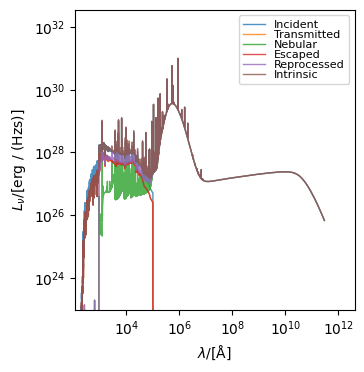

In [9]:
galaxy.stars.get_spectra_reprocessed(grid, fesc = 0.5)
galaxy.stars.plot_spectra()

`get_spectra_reprocessed()` actually generates more than just the reprocessed spectra, if also generates the `incident`, `transmitted`, `nebular`, and `intrinsic` `spectra`. If `fesc>0` it also generates `escaped`. The definitions of all of these are described in the spectra docs.

At anytime we can get a list of the spectra associated with a galaxy using:

In [10]:
print(galaxy.stars.spectra.keys())

dict_keys(['incident', 'transmitted', 'nebular', 'escaped', 'reprocessed', 'intrinsic'])


`get_spectra_reprocessed()` also includes a parameter allowing us to suppress Lyman-alpha emission, the Lyman-alpha escape fraction `fesc_LyA`.

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\lambda/[\\mathrm{Å}]$', ylabel='$L_{\\nu}/[\\mathrm{erg\\ / \\ (Hz s)}]$'>)

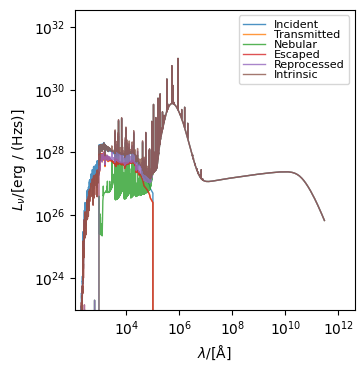

In [11]:
galaxy.spectra = {}  # reset spectra
galaxy.stars.get_spectra_reprocessed(grid, fesc = 0.5, fesc_LyA=0.0)
galaxy.stars.plot_spectra()

Dust attenuation in `synthesizer` is implemented via the flexible **Pacman** model. This model has a few features:

- In this model the parameter `fesc` denotes the fraction of light that entirely escapes a galaxy with no reprocessing by gas or dust.
- Like the `get_spectra_reprocessed()` you can also set the Lyman-alpha escape fraction `fesc_LyA` here. 
- It is possible to calculate spectra for both a young and old component each with different dust attenuation. 
- Various different dust attenuation (and emission) are provided. By default we use a simple power-law. 
- For dust attenuation the required free parameter here is `tau_v` the attenuation at 5500A. If an array is provided.

First, let's add dust attenuation using a simple screen model with a V-band optical depth `tau_v=0.5` and a power-law attenuation curve with `alpha=-1`.

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\lambda/[\\mathrm{Å}]$', ylabel='$L_{\\nu}/[\\mathrm{erg\\ / \\ (Hz s)}]$'>)

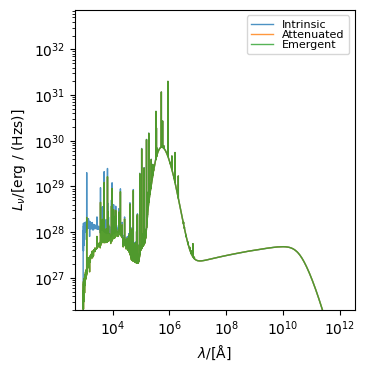

In [12]:
galaxy.spectra = {}  # reset spectra
galaxy.stars.get_spectra_pacman(grid, tau_v = 0.5, alpha=-1)
galaxy.stars.plot_spectra(spectra_to_plot=['intrinsic','attenuated', 'emergent'])

Next, let's allow `fesc` to vary. In the pacman model the fraction of light escaping reprocessing by gas also escape dust attenuation. 

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\lambda/[\\mathrm{Å}]$', ylabel='$L_{\\nu}/[\\mathrm{erg\\ / \\ (Hz s)}]$'>)

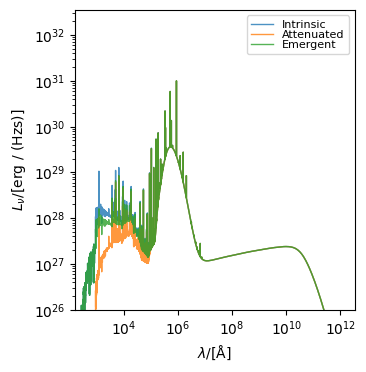

In [13]:
galaxy.spectra = {}  # reset spectra
galaxy.stars.get_spectra_pacman(grid, tau_v = 0.5, alpha=-1, fesc = 0.5)
galaxy.stars.plot_spectra(spectra_to_plot=['intrinsic','attenuated', 'emergent'])

Note, that despite the same `tau_v` the actual attenuation is much less. Fortunately if we want to know the true attenuation there is a method `A()` on Galaxy for that which take the wavelength.

In [14]:
# FIX COMING SOON
# galaxy.A(5500*Angstrom)

`get_spectra_pacman()` can also implement dust attenuation separately for both young and old components (where the threshold is set by `young_old_thresh` which is log10(threshold/yr)). In this case it is also necessary to provide `tau_v` and `alpha` as pairs of values describing the ISM and birth-cloud components. Note, young stellar populations feel attenuation from both the ISM and birth-cloud components.

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\lambda/[\\mathrm{Å}]$', ylabel='$L_{\\nu}/[\\mathrm{erg\\ / \\ (Hz s)}]$'>)

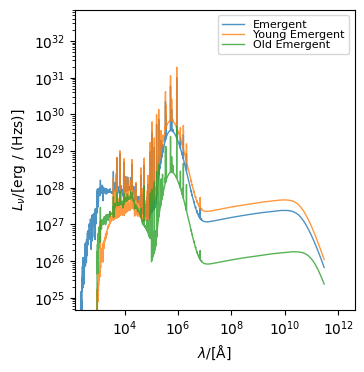

In [15]:
galaxy.spectra = {}  # reset spectra
tau_v_ISM = 0.5  # ISM component of dust attenuation
tau_v_BC = 0.5  # birth-cloud componest of dust attenuation
tau_v = [tau_v_ISM, tau_v_BC]
alpha = [-0.7, -1.3]
galaxy.stars.get_spectra_pacman(grid, tau_v = tau_v, alpha = alpha, young_old_thresh = 7.)
galaxy.stars.plot_spectra(spectra_to_plot = ['emergent', 'young_emergent', 'old_emergent'])

For users more familiar with the Charlot and Fall (2000) two component dust model `synthesizer` also includes a `get_spectra_CharlotFall()` method, which is really a wrapper around the more generic `get_spectra_pacman()` method. The difference is that `fesc` is implicitly assumed to `0.0` and there is a more familiar way of setting the parameters.

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\lambda/[\\mathrm{Å}]$', ylabel='$L/[\\mathrm{erg\\ / \\ s}]$'>)

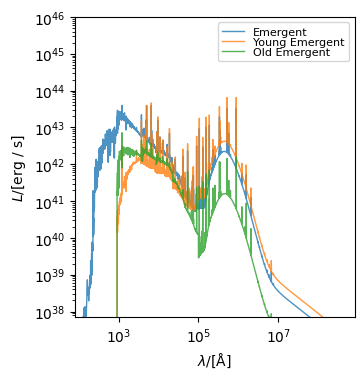

In [16]:
galaxy.stars.get_spectra_CharlotFall(grid, tau_v_ISM=0.5, tau_v_BC=0.5, alpha_ISM=-0.7, alpha_BC=-1.3)
galaxy.stars.plot_spectra(spectra_to_plot = ['emergent', 'young_emergent', 'old_emergent'], quantity_to_plot="luminosity")

Here we also demonstrate that the luminosity can be plotted instead of the spectral luminosity density by passing `quantity_to_plot="luminosity"` to the `plot_spectra` method. In fact, any quantity stored on an `Sed` can be passed to this argument to plot the respective quantity. These options include "lnu", "luminosity" or "llam" for rest frame spectra or "fnu", "flam" or "flux" for observed spectra.

### Dust emission

`synthesizer` can also be used to model emission through a simple energy balance approach. To do this we can supply a method that calculates an attenuated spectrum a `synthesizer.dust.emission.DustEmission` object. `synthesizer` has several built-in and these are described in **insert referenc**.

In [17]:

from synthesizer.dust.emission import Greybody
from unyt import K

If we provide a single attenuation (and curve) we need to only provide a single dust_emission model:

/opt/hostedtoolcache/Python/3.10.13/x64/lib/python3.10/site-packages/unyt/array.py:1813: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\lambda/[\\mathrm{Å}]$', ylabel='$L_{\\nu}/[\\mathrm{erg\\ / \\ (Hz s)}]$'>)

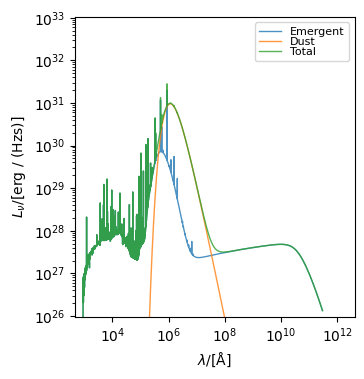

In [18]:
# initialise a greybody dust emission model
dust_emission_model = Greybody(30*K, 1.2)

galaxy.spectra = {}  # reset spectra
galaxy.stars.get_spectra_pacman(grid, tau_v = 0.5, alpha=-1, dust_emission_model = dust_emission_model)
galaxy.stars.plot_spectra(spectra_to_plot = ['emergent', 'dust', 'total'])


We can also specificy different dust emission models for the birth cloud and ISM (diffuse) dust separately:

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\lambda/[\\mathrm{Å}]$', ylabel='$L_{\\nu}/[\\mathrm{erg\\ / \\ (Hz s)}]$'>)

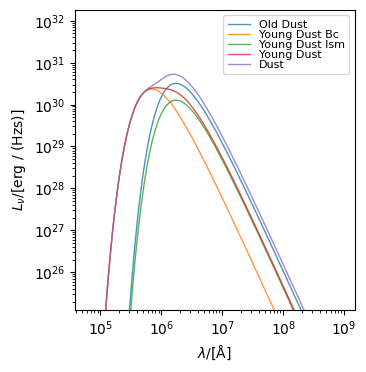

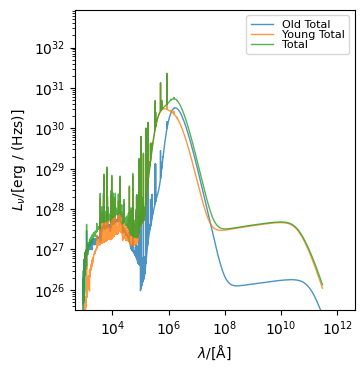

In [19]:

galaxy.spectra = {}  # reset spectra
tau_v_ISM = 0.5  # ISM component of dust attenuation
tau_v_BC = 0.5  # birth-cloud componest of dust attenuation
tau_v = [tau_v_ISM, tau_v_BC]
alpha = [-0.7, -1.3]
dust_emission_ISM = Greybody(20*K, 1.2)
dust_emission_BC = Greybody(50*K, 1.2)
dust_emission_model = [dust_emission_ISM, dust_emission_BC]

galaxy.stars.get_spectra_pacman(grid, tau_v = tau_v, alpha = alpha, young_old_thresh = 7., dust_emission_model=dust_emission_model)


galaxy.stars.plot_spectra(spectra_to_plot = ['old_dust', 'young_dust_BC', 'young_dust_ISM', 'young_dust', 'dust'])
galaxy.stars.plot_spectra(spectra_to_plot = ['old_total', 'young_total', 'total'])

### Galaxy summary

Like other objects in `synthesizer` we can also get a useful summary of the `Galaxy` object just using the `print` function:

In [20]:
print(galaxy)

-------------------------------------------------------------------------------
                            SUMMARY OF PARAMETRIC GALAXY                           
                           ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⣀⡀⠒⠒⠦⣄⡀⠀⠀⠀⠀⠀⠀⠀                          
                           ⠀⠀⠀⠀⠀⢀⣤⣶⡾⠿⠿⠿⠿⣿⣿⣶⣦⣄⠙⠷⣤⡀⠀⠀⠀⠀                          
                           ⠀⠀⠀⣠⡾⠛⠉⠀⠀⠀⠀⠀⠀⠀⠈⠙⠻⣿⣷⣄⠘⢿⡄⠀⠀⠀                          
                           ⠀⢀⡾⠋⠀⠀⠀⠀⠀⠀⠀⠀⠐⠂⠠⢄⡀⠈⢿⣿⣧⠈⢿⡄⠀⠀                          
                           ⢀⠏⠀⠀⠀⢀⠄⣀⣴⣾⠿⠛⠛⠛⠷⣦⡙⢦⠀⢻⣿⡆⠘⡇⠀⠀                          
                           ⠀⠀⠀+-+-+-+-+-+-+-+-+-+-+-+⡇⠀⠀                           
                           ⠀⠀⠀|S|Y|N|T|H|E|S|I|Z|E|R|⠃⠀⠀                           
                           ⠀⠀⢰+-+-+-+-+-+-+-+-+-+-+-+⠀⠀⠀                           
                           ⠀⠀⢸⡇⠸⣿⣷⠀⢳⡈⢿⣦⣀⣀⣀⣠⣴⣾⠟⠁⠀⠀⠀⠀⢀⡎                          
                           ⠀⠀⠘⣷⠀⢻⣿⣧⠀⠙⠢⠌⢉⣛⠛⠋⠉⠀⠀⠀⠀⠀⠀⣠⠎⠀                          
                        

We can also extract an spectra and generate broadband photometry. See the `Sed` and `Filter` tutorials:

In [21]:

sed = galaxy.stars.spectra['emergent']

tophats = {'U': {'lam_eff': 3650, 'lam_fwhm': 660},
           'V': {'lam_eff': 5510, 'lam_fwhm': 880},
           'J': {'lam_eff': 12200, 'lam_fwhm': 2130}}
fc = FilterCollection(tophat_dict=tophats, new_lam=grid.lam)
bb_lnu = sed.get_broadband_luminosities(fc)
print(bb_lnu)

{'U': unyt_quantity(6.60123966e+27, 'erg/(Hz*s)'), 'V': unyt_quantity(6.37193415e+27, 'erg/(Hz*s)'), 'J': unyt_quantity(8.87519832e+27, 'erg/(Hz*s)')}
